In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model, insert_attention_layer_in_keras
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from models.layers import ProjectionAttentionLayer
from typing import List
import pymf
import pandas as pd

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [2]:
# Set configs
img_height = 224
img_width = 224
batch_size = 128

test_datagen = CustomDataGenerator(
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [33]:
# Load pre-trained VGG-16 model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False

# Get layer kernel
kernel = model.get_layer('block4_conv3').kernel
flat_kernel = tf.reshape(kernel, [-1, kernel.shape[-1]]).numpy()

In [19]:
nmf = pymf.SNMF(flat_kernel, num_bases=4)
nmf.factorize(niter=1000)
p_mat = nmf.H

In [48]:
p_mat_dict = {}

for dim in [4, 17, 42, 90, 256, 512]:
    # Get projection matrix via SNMF
    n_comp = dim

    nmf = pymf.SNMF(flat_kernel, num_bases=n_comp)
    nmf.factorize(niter=1000)
    
    # Normalise columns of W using max norm
    d = np.diag(np.max(np.abs(nmf.W), axis=0))
    p_mat = d@nmf.H

    p_mat_dict[dim] = p_mat

In [3]:
import pickle
# with open('proj_mats_norm.pkl', 'wb') as f:
#     pickle.dump(p_mat_dict, f)

In [4]:
with open('proj_mats_norm.pkl', 'rb') as f:
    p_mat_dict  = pickle.load(f)

In [5]:
classes = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849', 'n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743'] 
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849'] 
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']

In [ ]:
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
model = insert_attention_layer_in_keras(p_mat_dict[17], model, ['block5_conv1'])

model.load_weights(f'models/baseline_fixed/{17}/model_weights')
# test_set.set_target_sampling(['n01608432'], [1])
# acc_val = test_model(model, test_set, 'n01608432')
# print(acc_val) 
#b = model.get_layer('attention_block5_conv1').projection_mat
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))

In [8]:
import matplotlib.pyplot as plt

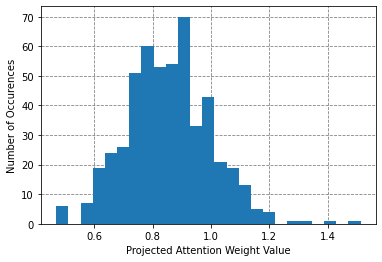

In [69]:
# a = model.get_layer('attention_block5_conv1').seeds.numpy()
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))
for dim in [256]:
    # model = tf.keras.models.load_model('models/vgg_trained')
    # model.trainable = False
    # model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/task_models_fixed_test/n02906734/{dim}/model_weights')
    pj =  (model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat)+model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=25)
    ax2.set_xlabel('Projected Attention Weight Value')
    ax2.set_ylabel('Number of Occurences')
    #ax2.set_xlim([0, 2])
    fig2.savefig(f'ex1.png', dpi=300)

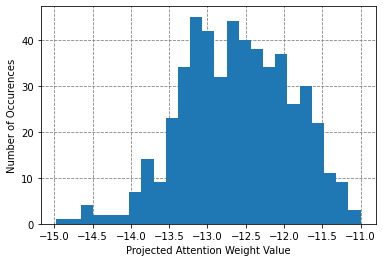

In [72]:
# a = model.get_layer('attention_block5_conv1').seeds.numpy()
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))
for dim in [256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    # model.load_weights(f'models/task_models_fixed_test/n02906734/{dim}/model_weights')
    pj =  (model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat)+model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=25)
    ax2.set_xlabel('Projected Attention Weight Value')
    ax2.set_ylabel('Number of Occurences')
    #ax2.set_xlim([0, 2])
    fig2.savefig(f'ex1_before.png', dpi=300)

In [ ]:
sparsity = {}
b = [0, 40, 18, 12]
for i in [4,17,42,256,512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[i], model, ['block5_conv1'])
    model.load_weights(f'models/task_models_fixed/n03887697/{i}/model_weights')
    a = model.get_layer('attention_block5_conv1').seeds.numpy()
    sparsity[f'{i}']=np.sum(a==0)/(a.shape[0]*a.shape[1])

    pj = model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=18)
    ax2.set_xlabel('(normalised) frequency * rank')
    ax2.set_ylabel('Number of Occurences')
    #ax2.set_xlim([0, 2])
    #fig2.savefig(f'e-{i}.png')

In [6]:
acc = [pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256]) for i in range(3)]
acc_baseline = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
#sparsity = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
ws = []

for cl in classes:
    for i in range(3):
        acc[i] = acc[i].append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    acc_baseline = acc_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #sparsity = sparsity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

#Begin the tests for each class (baseline)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    for cl in classes:
        test_set.set_target_sampling([cl], [1])
        acc_val = test_model(model, test_set, cl)
        acc_baseline.loc[classes.index(cl), dim] = acc_val

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        for j, i in enumerate(['', '2', '3']):
            model.load_weights(f'models/task_models_fixed/{cl}/{str(dim)}/model_weights{i}')
            test_set.set_target_sampling([cl], [1])
            acc_val = test_model(model, test_set, cl)
            acc[j].loc[classes.index(cl), dim] = acc_val
        # a = model.get_layer('attention_block5_conv1').seeds.numpy()
        # sparsity_val = np.sum(a==0)/(a.shape[0]*a.shape[1])
        # sparsity.loc[classes.index(cl), dim] = sparsity_val
        #print(acc_val)
        #ws.append(np.sum(np.where(((model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat )+ model.get_layer('attention_block5_conv1').bias)<0)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpiq0kc_x1.py, line 14)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpiq0kc_x1.py, line 14)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...
Computing accuracy...


Sensitivity model

In [7]:
def fp_model(model, test_set: CustomIterator, cl) -> None:
    """ Test the passed model for its hit rate on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    cls = np.array(test_set.classes)
    
    print('Computing rates...')
    not_target = np.where(cls!=test_set.class_indices[cl])[0]
    new_pred = pred[not_target]
    fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)
    accuracy = np.sum(pred == test_set.class_indices[cl])/len(pred)

    return fp_val, accuracy

In [11]:
test_set.reset_target_sampling()
# global_acc = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
# global_acc_base = []
#hr_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
fp = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256, 512])
#fp_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])

for cl in classes:
    #global_acc = global_acc.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #hr_baseline = hr_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    fp = fp.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0, 512:0}, ignore_index=True)
    #fp_baseline = fp_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# Begin the tests for each class (baseline)
# for dim in [512]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     model.load_weights(f'models/baseline_fixed/{dim}/model_weights')

#     pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
#     pred = np.argmax(pred, axis=-1)
#     cls = np.array(test_set.classes)
#     global_acc_base.append(np.sum(pred==cls))

#     print('Computing rates...')
#     for cl in classes:
#         not_target = np.where(cls!=test_set.class_indices[cl])[0]
#         new_pred = pred[not_target]
#         fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)

#         fp_baseline.loc[classes.index(cl), dim] = fp_val

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        for j, i in enumerate(['', '2', '3']):
            test_set.set_target_sampling([cl], [0.5], force_class_sampling=True)
            model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights{i}', )
            fp_val, acc_val = fp_model(model, test_set, cl)
            fp.loc[classes.index(cl), dim] = fp_val
            #global_acc.loc[classes.index(cl), dim] = acc_val

Computing rates...


IndexError: index 100 is out of bounds for axis 0 with size 100

In [315]:
#sparsity.to_csv('sparsity.csv', index=False)
acc.to_csv('acc.csv', index=False)
acc_baseline.to_csv('acc_baseline.csv', index=False)
fp.to_csv('false_alarm.csv', index=False)
fp_baseline.to_csv('false_alarm_base.csv', index=False)

Plots

In [8]:
dims = [17,42,90,256, 512]

In [7]:
# sparsity = pd.read_csv('sparsity.csv', names=['group', 'class', 4, 17, 42, 90, 256, 512], header=0)
# acc = pd.read_csv('acc.csv', names=['group', 'class', 4, 17, 42, 90, 256, 512], header=0)
# acc_baseline = pd.read_csv('acc_baseline.csv', names=['group', 'class',4,  17, 42, 90, 256, 512], header=0)
# fp = pd.read_csv('false_alarm.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0)
fp_baseline = pd.read_csv('false_alarm_base.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0)

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [10]:
sp_mes = np.array(sparsity[dims])
means = np.mean(sp_mes, axis=0)
errors = np.std(sp_mes, axis=0)/np.sqrt(sp_mes.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar([str(x) for x in dims], means, yerr=errors, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)
ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Sparsity')
ax.set_ylim([0,0.8])
#fig.savefig('sparsity_per_dim.png')

print(errors)

[0.00668249 0.01312201 0.01458999 0.02179132 0.02135102] [0.03342346 0.06518139 0.0928955  0.14163048 0.14898737]


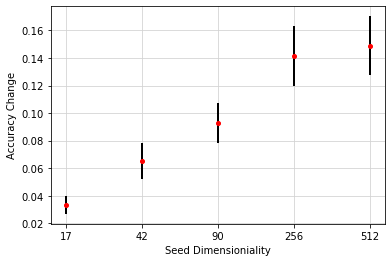

In [309]:
acc_change = np.array(acc[dims]) - np.array(acc_baseline[dims])

means = np.mean(acc_change, axis=0)
errors = np.std(acc_change, axis=0)/np.sqrt(acc_change.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar([str(x) for x in dims], means, yerr=errors, fmt='o', color='red', ecolor='black', elinewidth=2, markersize=4)


ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Accuracy Change')
#ax.set_ylim([0,0.22])
fig.savefig('acc_change_per_dim.png', dpi=300)

print(errors, means)

[0.00668249 0.01312201 0.01458999 0.02179132 0.02135102] [0.03342346 0.06518139 0.0928955  0.14163048 0.14898737]


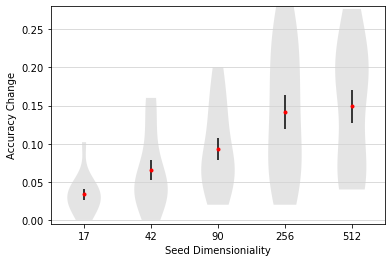

In [28]:
acc_change = np.array(acc[dims]) - np.array(acc_baseline[dims])

means = np.mean(acc_change, axis=0)
errors = np.std(acc_change, axis=0)/np.sqrt(acc_change.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[acc_change[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
#ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
#ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
#ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = means.tolist()
m.insert(0,0)
e = errors.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Accuracy Change')
ax.set_ylim([-0.005,0.28])
ax.set_xlim([0.5,5.5])
#fig.savefig('acc_change_per_dim_vio.png', dpi=300)

print(errors, means)

In [32]:
acc_sens = np.std(acc_change, axis=0)
for pair in [[4, 3], [3, 2], [2,1], [1,0]]:
    s2 = (13*(acc_sens[pair[0]]**2) + 13*(acc_sens[pair[1]]**2))/(13+13-2)
    t = (means[pair[0]] - means[pair[1]])/(np.sqrt((2*s2)/13))
    print(t)

0.2232592643498412
1.7205153080255877
1.307573333929406
1.996669581708014


Perceptual boost increases with dimensionality from 17 to 512. The highest perceptual boost was exhibited by dimensionality 512, however this was found to not be significant t(26)=0.22, p>0.5 suggesting that both operate with equal performance meaning there are around 256 redundant dimensions within the original decomposition as the seed mechanism at 50% reduction in dimensionality performs as well as the full dimensionality equivalent. The difference between the 256 and 90 dimensional models was found to be significant at t(26)=1.72, p<0.1 suggesting optimal dimensionality for the mechanism is the 256 dimensional model. Perceptual boost at all dimensions is apparent and provides evidence for the success of the mechanism, especially the 512-256 pair.

In [372]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

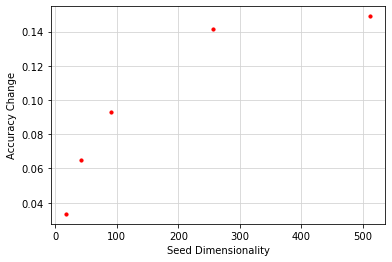

In [416]:
acc_change = np.array(acc[dims]) - np.array(acc_baseline[dims])
x = [i for i in dims]*14
x_quad = np.hstack([np.array(dims).reshape(-1, 1), np.array(dims).reshape(-1, 1)**2])
x_new = np.linspace(0, 512, 50).reshape(-1, 1)
x_new = np.hstack([x_new, x_new**2])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)

reg = LinearRegression().fit(np.vstack([x_quad, np.flip(x_quad, axis=0)]), np.hstack([means, np.flip(means)]).reshape(-1, 1))
ax.scatter(np.array(dims).flatten(), means.flatten(), marker='o', alpha=1, color='red', s=10)
# ax.plot(x_new[:, 0], reg.predict(x_new), 'r', label='Linear Fit')
# neww = dims.copy()
# newwm = means.tolist()
# for i in range(40): 
#     neww.append(512+i*10)
#     newwm.append(0.1489873715443)
# spl = UnivariateSpline(neww, newwm, k=3)
# xs = np.linspace(0, 600, 1000)
# plt.plot(xs, spl(xs), 'g', lw=3)

ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensionality')
ax.set_ylabel('Accuracy Change')
fig.savefig('acc_change_per_all_dims.png', dpi=300)

hr fp sens

[0.19224504 0.19373217 0.21137133 0.24191812 0.23458493] [4.33454804 4.25159784 4.23342794 4.27472975 4.28329547]


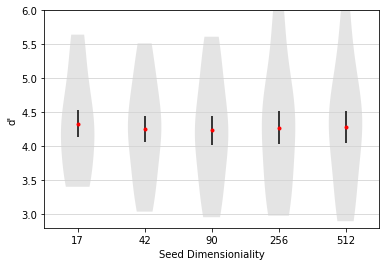

In [25]:
from scipy.stats import norm
sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
for cl in classes:
    sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

hr_arr = np.array(acc[dims])
hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
fp_arr = np.array(fp[dims])
z_hr = norm.ppf(hr_arr)
z_fp = norm.ppf(fp_arr)
sens = z_hr - z_fp
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error


#ax.errorbar([str(x) for x in dims], me_sen, yerr=err_sen, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[sens[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("d'")
ax.set_ylim([2.8,6])
ax.set_xlim([0.5,5.5])

#fig.savefig('sens_per_dim_vio.png', dpi=300)

print(err_sen, me_sen)

In [34]:
std_sens = np.std(sens, axis=0)
for pair in [[0, 4], [4, 3], [3,1], [1,2]]:
    s2 = (13*(std_sens[pair[0]]**2) + 13*(std_sens[pair[1]]**2))/(13+13-2)
    t = (me_sen[pair[0]] - me_sen[pair[1]])/(np.sqrt((2*s2)/13))
    print(t)

0.15645020905993032
0.023533593618692537
0.069099466319108
0.05867009791610988


Model sensitivity peaked for the lowest dimensionality of 17, then 512, 256, 42, and 90. All sensitivites to fall within the same range and match those found in Luo et al hence showing consistency in the balance of benefits and costs of the attention mechanism. A student t-test between the decreasing pairs of sensitivities reveals the null hypothesis that there is a difference between subsequent sensitivity means is under 50% or less than pure chance and max confidence exhibited at t(26)=0.16, p>0.5.

[0.06448279 0.05652039 0.0574309  0.05885186 0.07321617] [1.20505514 1.07404237 0.91090689 0.66350851 0.62577067]


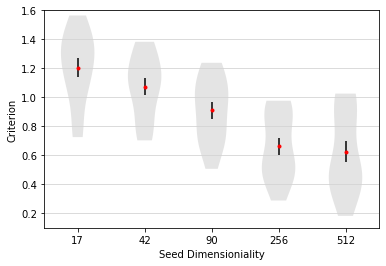

In [24]:
from scipy.stats import norm
sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
for cl in classes:
    sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

hr_arr = np.array(acc[dims])
hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
fp_arr = np.array(fp[dims])
z_hr = norm.ppf(hr_arr)
z_fp = norm.ppf(fp_arr)
sens = - (z_hr + z_fp) / 2
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error


#ax.errorbar([str(x) for x in dims], me_sen, yerr=err_sen, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[sens[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("Criterion")
ax.set_ylim([0.1,1.6])
ax.set_xlim([0.5,5.5])

fig.savefig('cri_per_dim_vio.png', dpi=300)

print(err_sen, me_sen)

Decreasing model
criterion suggests that as seed dimensionality increased,
the model was more biased in favour of a target class
response, which was more likely to result in a false
alarm

[0.03406087 0.0312603  0.02838507 0.02261645 0.02447675] [0.79611361 0.82227759 0.85284885 0.89640397 0.89938145]


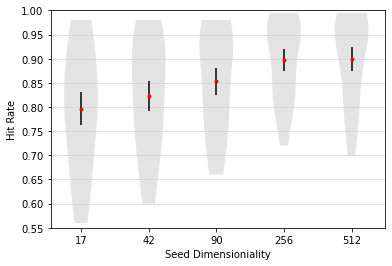

In [165]:
me_hr = np.mean(hr_arr, axis=0)
err_hr = np.std(hr_arr, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[hr_arr[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("Hit Rate")
ax.set_ylim([0.55, 1])
ax.set_xlim([0.55,5.5])
print(err_hr, me_hr)
fig.savefig('hr_per_dim_vio.png', dpi=300)

[8.81658673e-05 2.59571230e-04 4.78203766e-04 1.44952134e-03
 1.73774136e-03] [0.00047729 0.00100497 0.00188692 0.00434893 0.00483215]


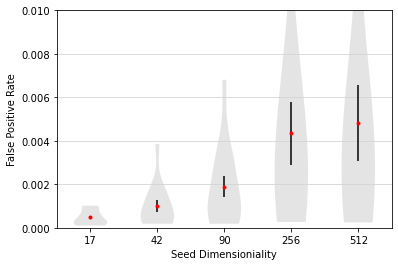

In [32]:
me_hr = np.mean(fp_arr, axis=0)
err_hr = np.std(fp_arr, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[fp_arr[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("False Positive Rate")
ax.set_ylim([0, 0.01])
ax.set_xlim([0.5,5.5])

print(err_hr, me_hr)
fig.savefig('fp_per_dim_vio.png', dpi=300)

Attention Weights

In [ ]:
s = {512:[],17:[], 42:[], 90:[], 256:[]}
p = {512:[],17:[], 42:[], 90:[], 256:[]}
s_b = {512:[],17:[], 42:[], 90:[], 256:[]}
p_b = {512:[],17:[], 42:[], 90:[], 256:[]}

# # Begin the tests for each class (baseline)
# for dim in [4, 17, 42, 90, 256]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        s[dim].extend(model.get_layer('attention_block5_conv1').seeds.numpy().tolist())
        p[dim].extend((model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias).numpy().tolist())
    
    # Baselines
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    s_b[dim].extend(model.get_layer('attention_block5_conv1').seeds.numpy().tolist())
    p_b[dim].extend((model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias).numpy().tolist())

[0.033068362789560386, 0.026953175943116508, 0.03981017539482301, 0.05010252761533375, 0.1284665916805219] [0.14168985345216334, 0.16341951795279014, 0.18940877160255887, 0.2167249519652121, 0.5089431875131457]


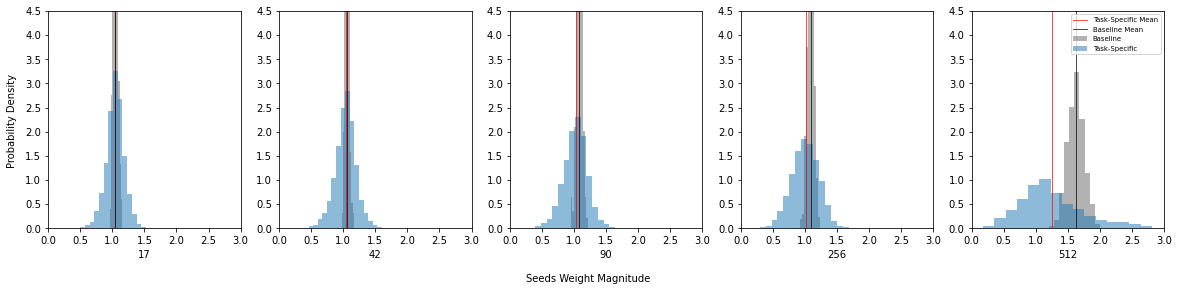

In [19]:
# for k,v in s.items():
#     s[k] = [item for sublist in v for item in sublist]
# for k,v in p.items():
#     p[k] = [item for sublist in v for item in sublist]
# for k,v in s_b.items():
#     s_b[k] = [item for sublist in v for item in sublist]
# for k,v in p_b.items():
#     p_b[k] = [item for sublist in v for item in sublist]

std_p = []
std_pb = []
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,4))
axes = [ax1, ax2, ax3, ax4, ax5]

for i,d in enumerate(dims):
    axes[i].set_axisbelow(True)
    # axes[i].yaxis.grid(color='gray', linestyle='dashed')
    # axes[i].xaxis.grid(color='gray', linestyle='dashed')
    axes[i].hist(p_b[d], bins=10, density=True, alpha=0.6, label='Baseline', color='grey')
    axes[i].hist(p[d], bins=20, density=True, alpha=0.5, label='Task-Specific',)
    axes[i].set_xlabel(str(d))
    axes[i].set_xlim([0, 3])
    axes[i].set_ylim([0, 4.5])
    axes[i].axvline(x=np.mean(p[d]), color='r', linewidth=0.7, label='Task-Specific Mean')
    axes[i].axvline(x=np.mean(p_b[d]), color='black', linewidth=0.7, label='Baseline Mean')
    std_p.append(np.std(p[d]))
    std_pb.append(np.std(p_b[d]))
    
fig2.text(0.5, -0.05, 'Seeds Weight Magnitude', ha='center', va='center')
fig2.text(0.1, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
#fig2.legend(fontsize='small', labels=['Task-Specific Mean', 'Baseline Mean', 'Baseline', 'Task-Specific'], bbox_to_anchor=[0.95,0.85])
axes[i].legend(fontsize='x-small',)
fig2.savefig(f'attention_spread.png', dpi=300)
    
print(std_pb, std_p)

In [20]:
import scipy

[0.7761381273199172, 0.8936235130069986, 1.0199298382379955, 0.7918860801664449, 0.09386399787104917] [4.3803656318081465, 5.089602541674148, 4.485394760386221, 2.9622855476022076, 0.14630526700127294]


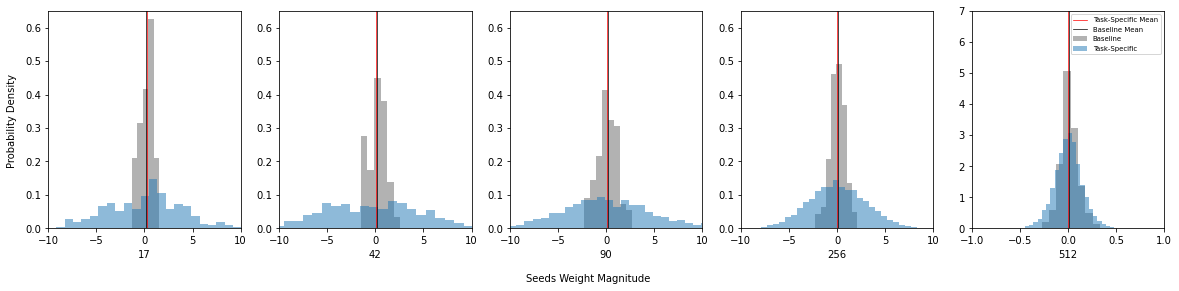

In [18]:
std_s = []
std_sb = []
b_b = [5, 6, 8,8,8]
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,4))
axes = [ax1, ax2, ax3, ax4, ax5]
for i, d in enumerate(dims):
    axes[i].set_axisbelow(True)
    # axes[i].yaxis.grid(color='gray', linestyle='dashed')
    # axes[i].xaxis.grid(color='gray', linestyle='dashed')
    axes[i].hist(s_b[d], bins=b_b[i], density=True, alpha=0.6, label='Baseline', color='grey', )
    axes[i].hist(s[d], bins=30, density=True, alpha=0.5, label='Task-Specific',)
    axes[i].set_xlim([-1, 1] if d==512 else [-10, 10])
    axes[i].set_ylim([0, 7] if d==512 else [0, 0.65])
    axes[i].set_xlabel(str(d))
    axes[i].axvline(x=np.mean(s[d]), color='r', linewidth=0.7, label='Task-Specific Mean')
    axes[i].axvline(x=np.mean(s_b[d]), color='black', linewidth=0.7, label='Baseline Mean')
    std_s.append(np.std(s[d]))
    std_sb.append(np.std(s_b[d]))

fig2.text(0.5, -0.05, 'Seeds Weight Magnitude', ha='center', va='center')
fig2.text(0.1, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
# axes[i].set_xlabel('Projected Attention Weight Magnitude')
# axes[i].set_ylabel('Probability Density')
#fig2.legend(fontsize='small', labels=['Task-Specific Mean', 'Baseline Mean', 'Baseline', 'Task-Specific'], bbox_to_anchor=[0.95,0.85])
axes[i].legend(fontsize='x-small',)
fig2.savefig(f'seed_spread.png', dpi=300)
print(std_sb, std_s)

In [24]:
for pair in [[17,42], [42,90], [90,256], [256,512]]:
    print(scipy.stats.spearmanr(p[pair[0]], p[pair[1]]))
for pair in [[17,42], [42,90], [90,256], [256,512]]:
    print(scipy.stats.spearmanr(p_b[pair[0]], p_b[pair[1]]))

SpearmanrResult(correlation=0.5680977178343045, pvalue=0.0)
SpearmanrResult(correlation=0.5568939806170715, pvalue=0.0)
SpearmanrResult(correlation=0.3927825306688035, pvalue=4.3269350732746705e-263)
SpearmanrResult(correlation=0.4119916125236197, pvalue=8.104625798506245e-292)
SpearmanrResult(correlation=0.3476586192936679, pvalue=5.430042661653434e-16)
SpearmanrResult(correlation=0.4749498603815474, pvalue=3.612670697864645e-30)
SpearmanrResult(correlation=0.3231041537920143, pvalue=6.62450834906289e-14)
SpearmanrResult(correlation=0.22882441549078178, pvalue=1.6528785130369358e-07)


Per-filter analysis

In [ ]:
f_dict = {d:{i:[] for i in range(512)} for d in dims}
f_dict_b = {d:{i:[] for i in range(512)} for d in dims}

for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias)
        for i in range(512):
            f_dict[dim][i].append(pj[i])
    
    # Baselines
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias)
    for i in range(512):
        f_dict_b[dim][i].append(pj[i])

In [196]:
f_dict_m = {d:{i:[] for i in range(512)} for d in dims}
f_dict_b_m = {d:{i:[] for i in range(512)} for d in dims}

for k,v in f_dict_m.items():
    for j,p in f_dict_m[k].items():
        f_dict_m[k][j] = [np.mean(f_dict[k][j]), np.std(f_dict[k][j])]
for k,v in f_dict_b_m.items():
    for j,p in f_dict_b_m[k].items():
        f_dict_b_m[k][j] = [np.mean(f_dict_b[k][j]), np.std(f_dict_b[k][j])]

In [ ]:
std_s = []
std_sb = []
b_b = [5, 6, 8,8,8]
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,4))
axes = [ax1, ax2, ax3, ax4, ax5]



for i, d in enumerate(dims):
    axes[i].set_axisbelow(True)
    # axes[i].yaxis.grid(color='gray', linestyle='dashed')
    # axes[i].xaxis.grid(color='gray', linestyle='dashed')
    axes[i].
    # axes[i].set_xlim([-1, 1] if d==512 else [-10, 10])
    # axes[i].set_ylim([0, 7] if d==512 else [0, 0.65])
    axes[i].set_xlabel(str(d))
    axes[i].axvline(x=np.mean(s[d]), color='r', linewidth=0.7, label='Task-Specific Mean')
    axes[i].axvline(x=np.mean(s_b[d]), color='black', linewidth=0.7, label='Baseline Mean')
    std_s.append(np.std(s[d]))
    std_sb.append(np.std(s_b[d]))

fig2.text(0.5, -0.05, 'Seeds Weight Magnitude', ha='center', va='center')
fig2.text(0.1, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
# axes[i].set_xlabel('Projected Attention Weight Magnitude')
# axes[i].set_ylabel('Probability Density')
#fig2.legend(fontsize='small', labels=['Task-Specific Mean', 'Baseline Mean', 'Baseline', 'Task-Specific'], bbox_to_anchor=[0.95,0.85])
axes[i].legend(fontsize='x-small',)
fig2.savefig(f'seed_spread.png', dpi=300)
print(std_sb, std_s)

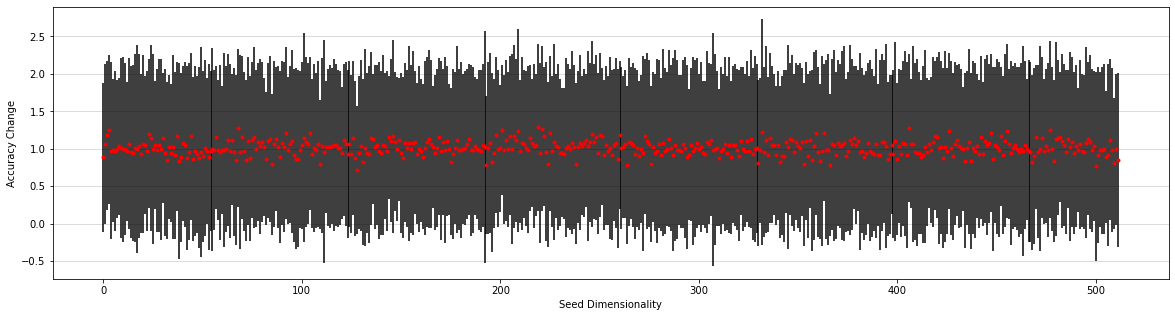

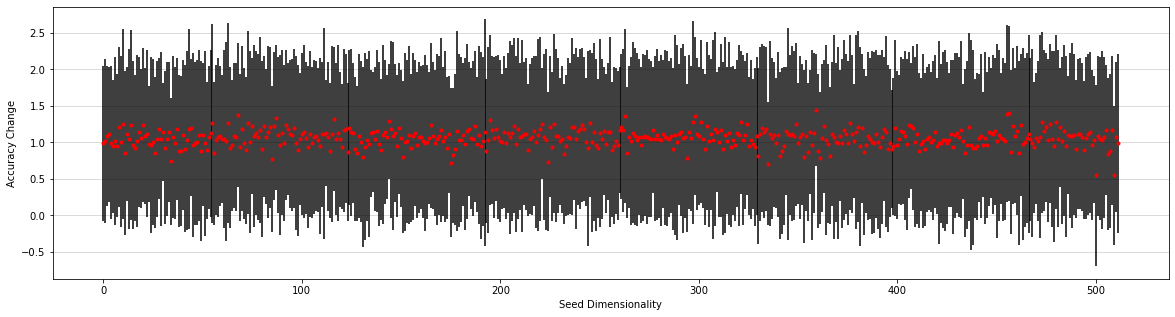

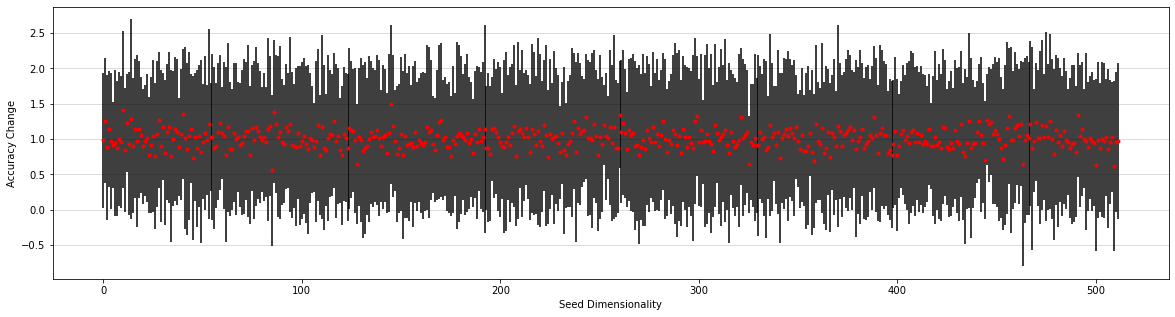

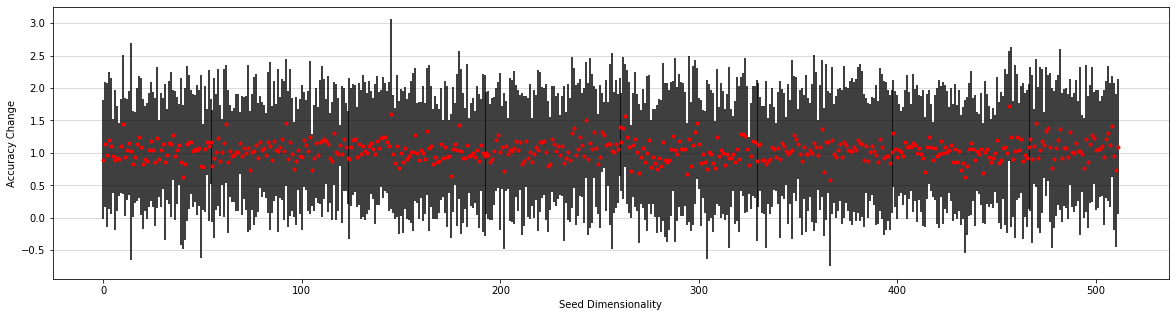

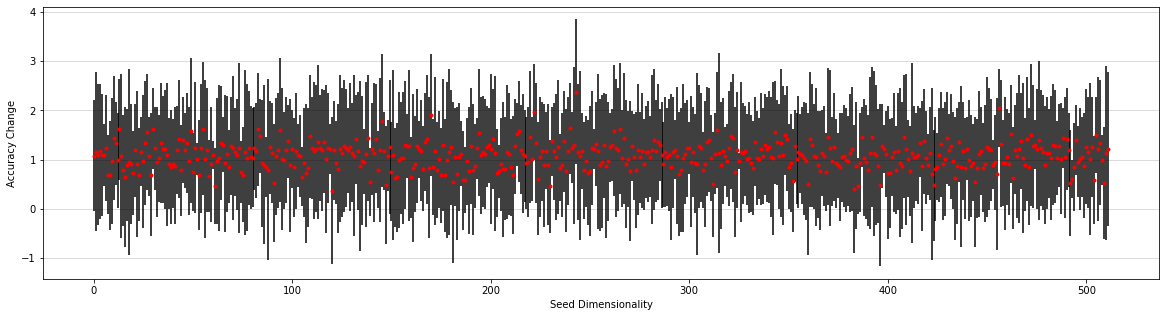

In [197]:
for d in dims:
    fig, ax = plt.subplots(figsize=(20,5))
    ax.set_axisbelow(True)
    ax.errorbar([n for n in f_dict[d].keys()], [m[0] for m in f_dict[d].values()], yerr=[m[1] for m in f_dict[d].values()], fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)
    ax.grid(color='lightgrey', linestyle='-', axis='y')
    ax.set_xlabel('Seed Dimensionality')
    ax.set_ylabel('Accuracy Change')
    # fig.savefig('acc_change_per_all_dims.png', dpi=300)

In [200]:
d_m = {i:[] for i in range(512)} 
d_b_m = {i:[] for i in range(512)} 

for k,v in f_dict_m.items():
    for j,p in f_dict_m[k].items():
        d_m[j].append(p[0])
for k,v in f_dict_b_m.items():
    for j,p in f_dict_b_m[k].items():
        d_b_m[j].append(p[0])
for k,v in d_m.items():
    d_m[k] = np.mean(d_m[k])
for k,v in d_b_m.items():
    d_b_m[k] = np.mean(d_b_m[k])

(0.0, 1.2)

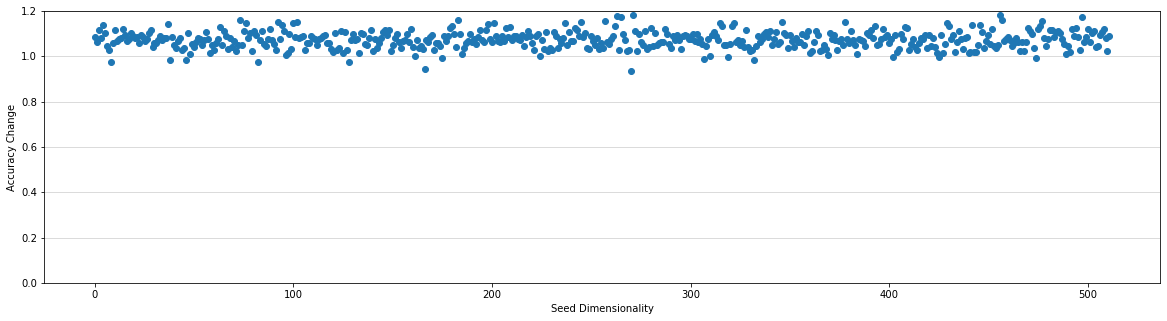

In [202]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_axisbelow(True)
ax.scatter(list(d_m.keys()), list(d_m.values()))
ax.grid(color='lightgrey', linestyle='-', axis='y')
ax.set_xlabel('Seed Dimensionality')
ax.set_ylabel('Accuracy Change')
ax.set_ylim([0, 1.2])
# fig.savefig('acc_change_per_all_dims.png', dpi=300)

In [ ]:
s_w = {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}
s_w_b =  {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}

for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds)
        for i in range(dim):
            s_w[dim][i].append(pj[i])
    
    # Baselines
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds)
    for i in range(dim):
        s_w_b[dim][i].append(pj[i])

f_dict_m = {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}
f_dict_b_m = {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}

for k,v in s_w.items():
    for j,p in s_w[k].items():
        f_dict_m[k][j] = [np.mean(s_w[k][j]), np.std(s_w[k][j])]
for k,v in s_w_b.items():
    for j,p in s_w_b[k].items():
        f_dict_b_m[k][j] = [np.mean(s_w_b[k][j]), np.std(s_w_b[k][j])]

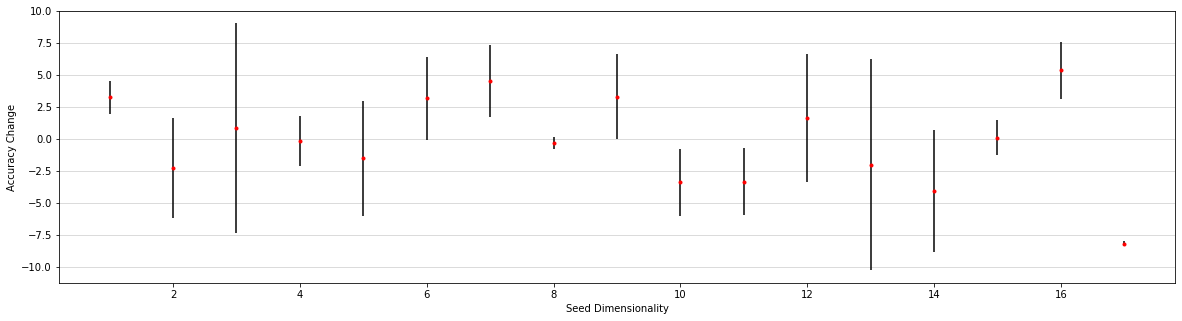

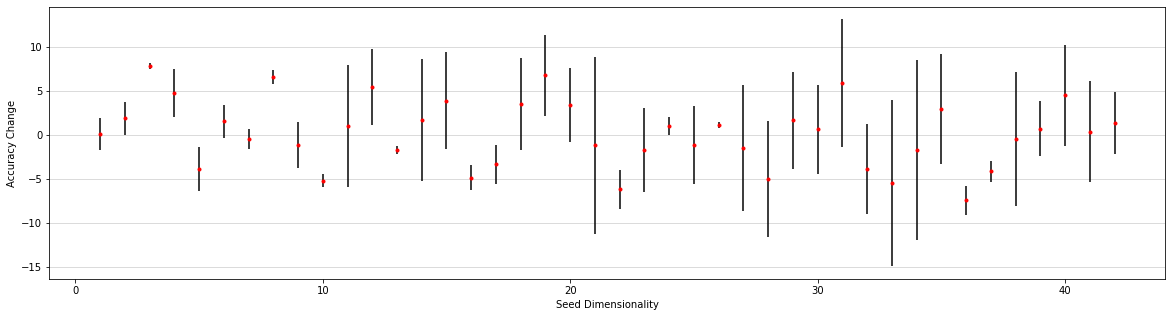

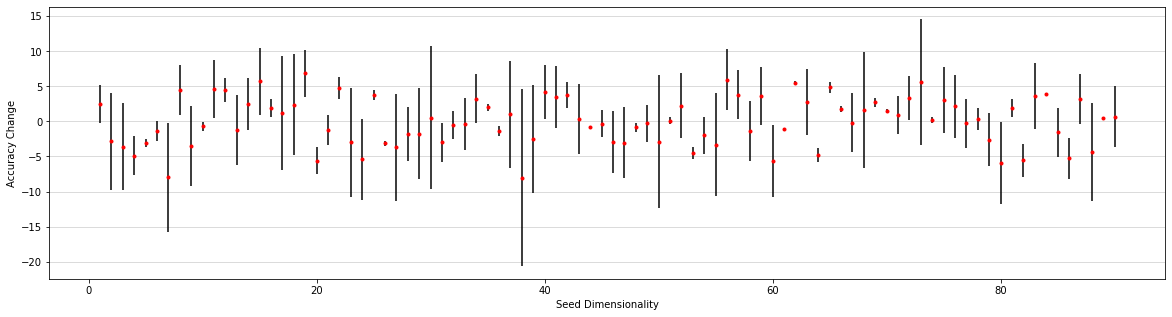

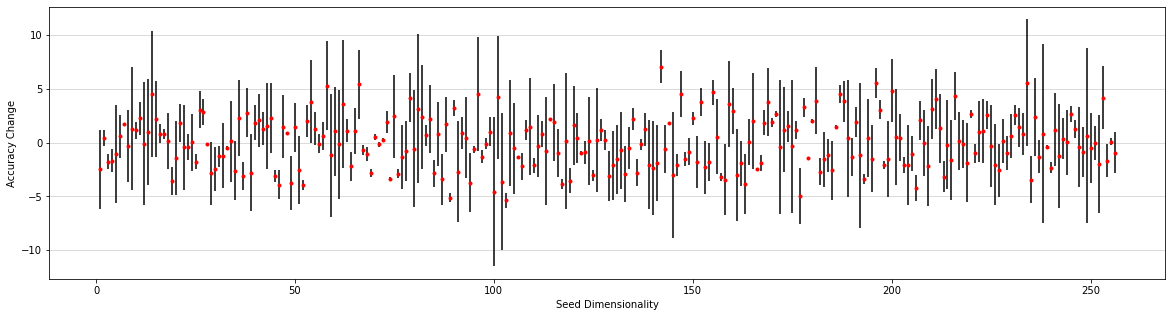

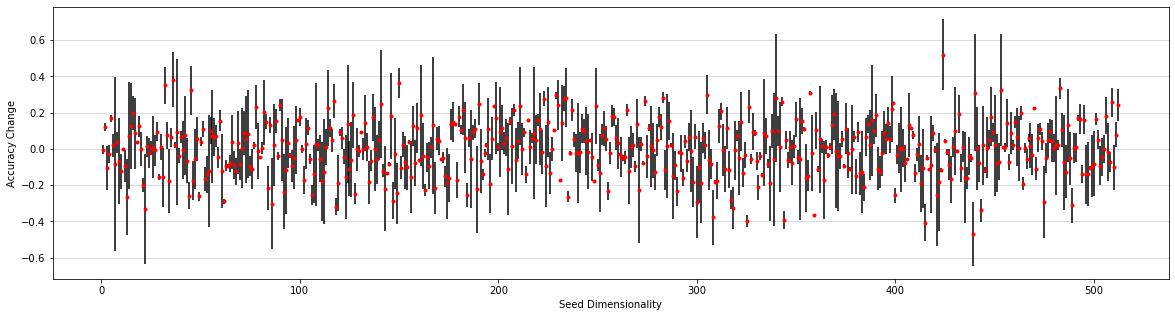

In [31]:
for d in dims:
    fig, ax = plt.subplots(figsize=(20,5))
    ax.set_axisbelow(True)
    ax.errorbar([n+1 for n in s_w[d].keys()], [m[0] for m in s_w[d].values()], yerr=[m[1] for m in s_w[d].values()], fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)
    ax.grid(color='lightgrey', linestyle='-', axis='y')
    ax.set_xlabel('Seed Dimensionality')
    ax.set_ylabel('Accuracy Change')
    # fig.savefig('acc_change_per_all_dims.png', dpi=300)